In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

In [4]:
import tensorflow as tf

In [5]:
import zipfile


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=False)

# manually extracting to ensure correct path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_path))

# setted dataset paths
PATH = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# create train,validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)


# Inspect class names
class_names = train_dataset.class_names
print("Class names:", class_names)



68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Class names: ['cats', 'dogs']


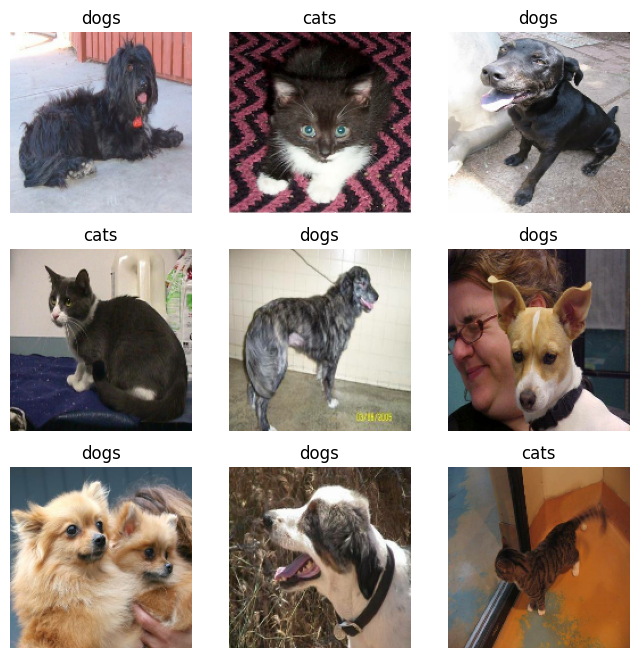

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')



---



# **Test Data Creation**

As the original dataset doesn't contain a test set, you need to create test data. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality and now split your validation dataset into two parts -- one part remains as validation, and the other part is a test dataset.

In [7]:
val_batches  = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

tf.data.experimental.cardinality(dataset) gives the number of batches in a dataset, it counts how many batches are in your original validation_dataset.

take(n) takes the first n batches from the dataset.
Here, val_batches // 5 means 1/5th (20%) of the validation dataset is test set, Example: If val_batches = 32, then 32 // 5 = 6 batches go into test_dataset.

skip(n) skips the first n batches, this way remaining 80% of the validation dataset is kept as the new validation set.
Example: If val_batches = 32 originally, after skipping 6, next 26 batches left for validation.

In [8]:
print('Number of validation batches --  %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches --  %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches --  26
Number of test batches --  6




---



# Optimize Data pipeline Performance

tf.data.AUTOTUNE --
Instead of manually setting a number (like buffer_size=1 or buffer_size=5), AUTOTUNE tells TensorFlow to dynamically tune the prefetch buffer size at runtime, TensorFlow monitors the training loop and automatically decides the optimal number of batches to prefetch.

prefetch() is a performance optimization for TensorFlow tf.data pipelines,
It allows the CPU to prepare the next batch of data while the GPU,TPU is busy training on the current batch.

Without prefetching, GPU trains on a batch, then waits while CPU loads/preprocesses the next batch.

With prefetching, next batch is ready in memory when the GPU finishes the current step i.e removes idle time.

Train dataset -- avoids GPU starvation while training, speeds up epoch times.

Validation dataset -- ensures validation evaluation doesnt bottleneck.

Test dataset -- ensures test evaluation runs smoothly without waiting for data.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



---



# **Data Augmentation**

When you don't have a large no of images in dataset, its better choice to artificially introduce sample diversity by applying random, yet realistic, transformations to the existing training images, such as rotation and horizontal flipping, zoom, cropping, Resizing, rescaling etc. This helps the model to get expose different aspects of the training data and reduce overfitting.

[data augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [10]:
from tensorflow.keras import layers

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

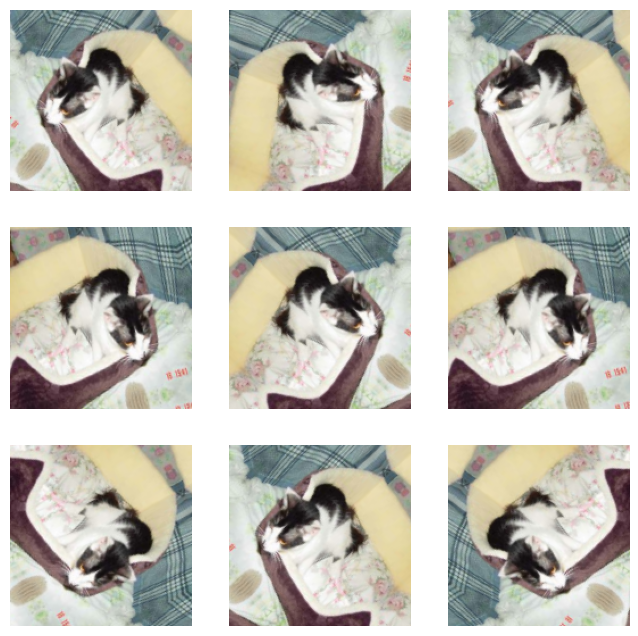

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(8, 8))
  image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# **Rescaling Pixel Values**

download tf.keras.applications.MobileNetV2 use it as base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. So to rescale them, we use the preprocessing method that includes this model.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Alternatively, you can also rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.



---



# **Creating the Base Model from the Pre-Trained Convnets**

Pre-trained models are like well-trained detectives for images. They study pictures from the dataset, where each image has a label telling whats in it. These models have learned to spot important details in pictures. We can either teach them more about specific tasks to detect the features according to our needs. Some of the pre-trained models we will look are MobileNet, Resnet50, AlexNet.

| Model            | Parameters | Model Size  | Speed       | Accuracy | Best Use Case                             |
| ---------------- | ---------- | ----------- | ----------- | -------- | ----------------------------------------- |
| **MobileNetV2**  | ~3.5M      | Lightweight | Very Fast   |  Good   | **Mobile & small dataset classification** |
| **ResNet50/101** | 25–44M     | Heavy       |  Slower    |  Higher | **High-accuracy tasks (big data)**        |
| **AlexNet**      | 60M        | Very Heavy  |  Outdated  |  Low   | **Research only (2012 model)**            |


You will now create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

MobileNet is a lightweight neural network architecture designed for mobile and embedded vision applications. It utilizes depthwise separable convolutions to reduce computational complexity while maintaining high accuracy in image classification tasks. MobileNet comes in various versions like MobileNetV1, V2, and V3, each offering improvements in efficiency and performance.

-  Firstly, you need to pick which layer of MobileNet V2 you will use for feature extraction.
- The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.
- Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the
"bottleneck layer". The bottleneck layer features retain more generality as compared to the final or top layer.

**Using Pre-Trained Models for Feature Extraction**

Feature Extraction is process of converting raw image data into set of relevant features that can be used to represent and classify the images based on patterns, textures, colors and structures within the images.

IMG_SIZE is usually (160, 160) or (224, 224), (3,) means 3 color channels (Red, Green, Blue).

IMG_SHAPE becomes (160, 160, 3) or (224, 224, 3) defines the input shape for your CNN model.

input_shape=IMG_SHAPE	is the input image shape (like 160×160×3).

include_top = False	removes the final fully connected (classification) layers of MobileNetV2. this is because you will add your own classifier for your dataset (Cats vs Dogs).

weights='imagenet'	loads pretrained weights from the ImageNet dataset these pretrained weights help your model learn features faster without starting from scratch.

In [14]:
# creating the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

In [15]:
image_batch, label_batch = next(iter(train_dataset))

# gets one batch of images and labels from your training dataset.
# example, if your batch size is 32:
# image_batch.shape - (32, 160, 160, 3)
# label_batch.shape - (32,) (labels for each image)

In [16]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


above code Passes the batch of images through MobileNetV2, and instead of predicting classes, it outputs feature maps (since include_top=False).

feature_batch.shape might look like (32, 5, 5, 1280)

32 = number of images

5×5 = spatial size of extracted features

1280 = number of filters (features extracted)



---



In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top level classifier.

Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.


In [17]:
base_model.trainable = False

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non trainable weights will destroy what the model has learned.

In [18]:
#base model architecture

base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)



---



**Adding a classification head**

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


GlobalAveragePooling2D() layer takes each 5×5 feature map and averages all its values, so for every image in the batch each of the 1280 feature maps (5×5 grid) -> 1 average value

The result becomes a 1280-dimensional vector, this operation removes spatial information (the "where") but keeps semantic strength (the "what").

Advantages

- Flattening (5×5×1280) to (32, 32000) — huge number of parameters.

- Global average pooling reduces this to (32, 1280) — compact and generalizable.

- Less overfitting, GAP has no trainable parameters and acts like a regularizer.



---



Applying a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


- Dense(1) means we have one output neuron, suitable for Binary classification cat (0) or dog (1), produces a single raw score (called a logit)

- feature_batch_average.shape = (32, 1280), Dense layer multiplies each 1280-D feature vector by its weights produces 1 output per image.
so the output shape becomes prediction_batch.shape = (32, 1)

base model (MobileNetV2) acts like a powerful feature extractor as it identifies patterns like fur texture, ears etc.

Dense(1) neuron acts like a judge that looks at those 1280 clues and decides does this look more like a cat (0) or a dog (1)

| Step     | Layer                  | Input Shape         | Output Shape       | Purpose                   |
| -------- | ---------------------- | ------------------- | ------------------ | ------------------------- |
| CNN Base | MobileNetV2            | `(32, 160, 160, 3)` | `(32, 5, 5, 1280)` | Extract deep features     |
| GAP      | GlobalAveragePooling2D | `(32, 5, 5, 1280)`  | `(32, 1280)`       | Condense features         |
| Dense(1) | Fully Connected        | `(32, 1280)`        | `(32, 1)`          | Produce binary prediction |




---



---



**Building a model** by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.

As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

1. input shape, each image has height = 160, width = 160, and 3 color channels (RGB).

2. apply real-time image transformations (rotation, flipping, zooming).
this helps the model generalize better and does not overfit to exact training images.

3. preprocess_input scales pixel values (between -1 and 1 for MobileNetV2)
and it ensures the input images are in the same format the base model was originally trained on (ImageNet).

4. MobileNetV2 base model processes the images and extracts deep feature maps (shapes, textures, patterns), training=False keeps BatchNormalization layers in inference mode to prevent them from updating their running statistics, which could otherwise destroy the learned ImageNet knowledge.

5. output of the base model is a 3D tensor (5, 5, 1280) feature map per image, Global Average Pooling converts this to a 1D vector by averaging each feature map to (batch_size, 1280) this compresses spatial information while retaining the important features.

6. Randomly drops out 20% of neurons during training to reduce overfitting to help the model rely on multiple neurons instead of memorizing training data patterns.

7. prediction_layer Dense(1) or Dense(num_classes) makes the final prediction eg Dense(1) is Binary classification (cat vs dog), Dense(5, activation='softmax') is 5-class classification

8. tf.keras.Model(inputs, outputs) connects all layers from input to output into a single end-to-end model, now we can train (model.fit) or evaluate (model.evaluate) this complete model.



In [22]:
base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)



---



# **Model Training**

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 626ms/step - accuracy: 0.4074 - loss: 0.9075


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.89
initial accuracy: 0.40


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 984ms/step - accuracy: 0.4345 - loss: 0.8909 - val_accuracy: 0.6522 - val_loss: 0.5832
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 979ms/step - accuracy: 0.6274 - loss: 0.6486 - val_accuracy: 0.8032 - val_loss: 0.4233
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 970ms/step - accuracy: 0.7283 - loss: 0.5102 - val_accuracy: 0.8601 - val_loss: 0.3254
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 981ms/step - accuracy: 0.7930 - loss: 0.4098 - val_accuracy: 0.8899 - val_loss: 0.2641
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 970ms/step - accuracy: 0.8383 - loss: 0.3441 - val_accuracy: 0.9171 - val_loss: 0.2206
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 967ms/step - accuracy: 0.8582 - loss: 0.3198 - val_accuracy: 0.9344 - val_loss: 0.1920
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 958ms/step - accuracy: 0.8861 - loss: 0.2714 - val_accuracy: 0.9381 - val_loss: 0.1698
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8912 - loss: 0.2490 - val_accurac

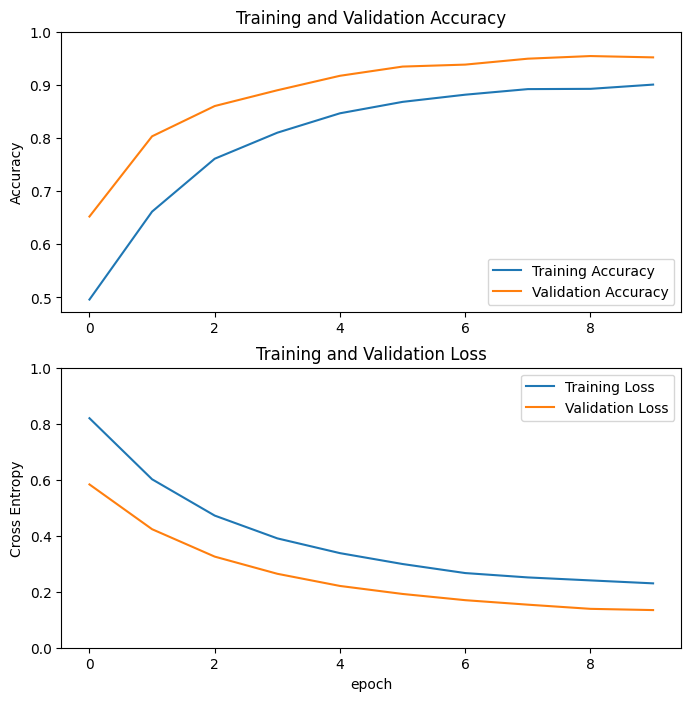

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


1. Validation Accuracy (orange) stays consistently high, Training Accuracy (blue) fluctuates slightly and remains lower than validation accuracy.

2. model is generalizing well — it performs better on unseen data (validation) than on training data.

3. fluctuations in training accuracy suggest that the learning rate is small and training is stable, without overfitting.


1. Training and Validation Loss, both losses are very low (< 0.15), which shows strong performance.

2. Validation loss (orange) is lower than training loss (blue) is a sign of good generalization.



---



---



In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print('Number of layers in the base model --  ', len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model --   154


Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [32]:
len(model.trainable_variables)

56

Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,epochs = total_epochs, initial_epoch = history.epoch[-1], validation_data = validation_dataset)



Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8063 - loss: 0.4708 - val_accuracy: 0.9740 - val_loss: 0.0853
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8770 - loss: 0.3088 - val_accuracy: 0.9777 - val_loss: 0.0723
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9097 - loss: 0.2227 - val_accuracy: 0.9802 - val_loss: 0.0652
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9268 - loss: 0.1871 - val_accuracy: 0.9814 - val_loss: 0.0599
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9233 - loss: 0.1659 - val_accuracy: 0.9839 - val_loss: 0.0513
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9402 - loss: 0.1395 - val_accuracy: 0.9851 - val_loss: 0.0444
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9430 - loss: 0.1318 - val_accuracy: 0.9839 - val_loss: 0.0444
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9346 - loss: 0.1412 - val_accuracy: 0.9851 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc     = acc + history_fine.history['accuracy']
val_acc = val_acc + history_fine.history['val_accuracy']

loss     = loss + history_fine.history['loss']
val_loss =  val_loss + history_fine.history['val_loss']

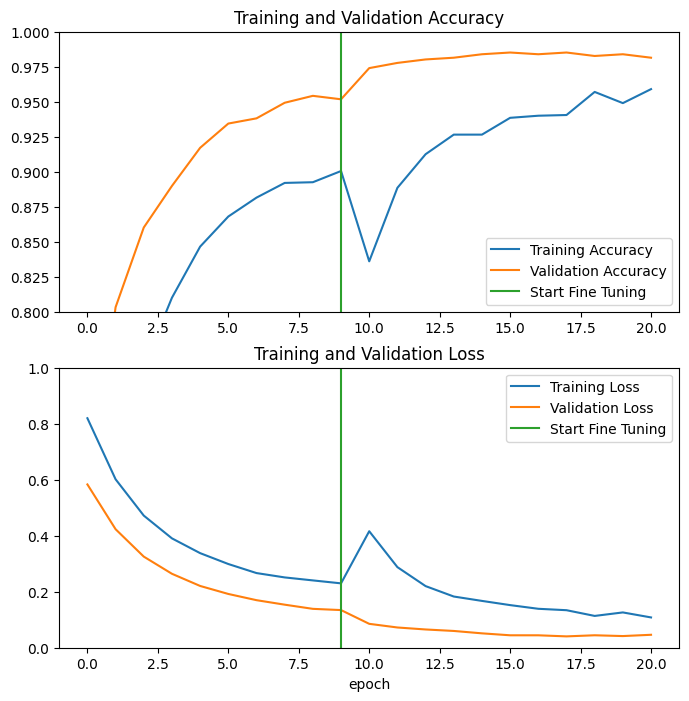

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epochs 0–9 is Feature Extraction Phase
(Base model frozen, only the top Dense layers trained)

Epochs 10–20 is Fine-Tuning Phase
(Top layers of MobileNetV2 unfrozen, learning rate reduced)

Training & Validation Accuracy --

- Validation accuracy rises from 0.80 to 0.95 in Epochs 0–9,  classifier learns quickly using powerful pretrained feature maps.

- Training accuracy lags behind (0.90)
Normal because only the classifier is being trained, while base model features remain static, so we have effectively transferred generic ImageNet features to new dataset (cats vs dogs).

- After fine-tuning starts,Epochs 10–20 both accuracies improve gradually, training accuracy moves from 0.96–0.97

- Validation accuracy stabilizes around 0.98–0.99, no sudden drops so fine-tuning was stable and

Fine-tuning refines higher-level MobileNetV2 filters (texture, fur pattern, facial shape features) these updates improved classification confidence, so higher validation accuracy.

Training & Validation Loss --

- Epochs 0–9 (Feature Extraction Phase) training loss decreases so model quickly adapts top layers.

- Validation loss also decreases so good model generalization.

- Epochs 10–20 (Fine-Tuning Phase) a spike in training loss because the newly unfrozen layers begin updating, causing temporary instability.

- soon after, both training and validation loss drop gradually.

In [38]:

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.9878 - loss: 0.0283
Test accuracy : 0.9895833134651184


Predictions:
 [0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1]


Labels:
 [0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1]


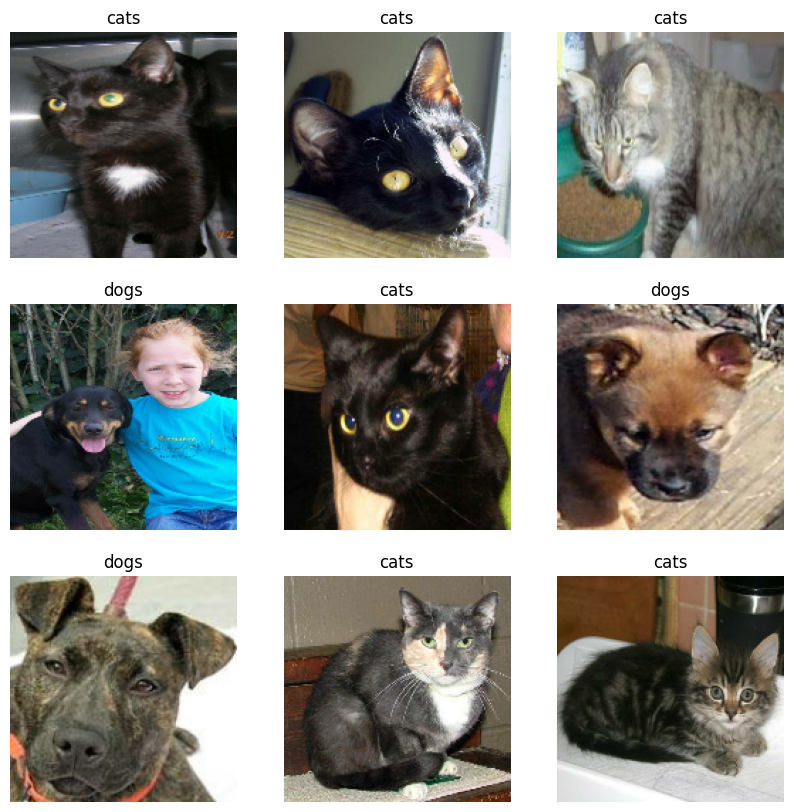

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('\n')
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")